In [1]:
import os 
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann
import diffxpy.api as de
import batchglm.api as glm
from batchglm.pkg_constants import TF_CONFIG_PROTO
#data integration package
#import scIB 
import scanpy.external as sce

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

#import rpy2.rinterface_lib.callbacks
import logging, warnings
#from rpy2.robjects import pandas2ri
#import anndata2ri


sc.settings.verbosity = 3
sc.logging.print_versions()

/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12

In [4]:
adata = sc.read('./../data/processed/cellxgene.h5ad')

In [5]:
adata.rename_categories('louvain', ['Astro 1', 'Oligo 1', 'CCK 1', 'Oligo 2', 'Glut 1', 'Endothelial',\
                                    'Glut 2', 'Microglia 1', 'OPCs', 'Microglia 2', \
                                    'CCK 2 (?)', 'Pericytes', 'Glut 3', 'CCK 3', 'GABA', \
                                    'Endothelial 2', 'Astro 2', 'Cajal-Retzius', 'Astro 3', \
                                    'Neurons (?)', 'Oligo (?)', 'Choroid Plexus', 'Ependymal', \
                                    'CCK 4', 'NPCs', 'Vascular', 'Macrophages', 'Meningeal', '??'])

In [6]:
import pickle 
with open('../results/diffxpy_louvain.pickle', 'rb') as f:
    de_results_louvain = pickle.load(f)
with open('../results/diffxpy_celltype.pickle', 'rb') as f:
    de_results_celltype = pickle.load(f)

# Look at the results

In [22]:
de_results_listofdicts = []
for i, item in enumerate(de_results_celltype):
    de_results_dict = {
        'cell_type': de_results_celltype[i],
        'louvain': de_results_louvain[i]    
    }
    if i == 0:
        de_results_dict['pairtest'] = 'BL Ctrl vs BL Stress'
    elif i == 1:
        de_results_dict['pairtest'] = 'ELS Ctrl vs ELS Stress'
    elif i == 2:
        de_results_dict['pairtest'] = 'BL Ctrl vs ELS Ctrl'
    elif i == 3:
        de_results_dict['pairtest'] = 'BL Stress vs ELS Stress'
    de_results_listofdicts.append(de_results_dict)

In [49]:
def de_postprocessing(de_results_listofdicts, adata):
    de_post = []
    
    for de_results_dict in de_results_listofdicts:
        for clust_type in ['cell_type', 'louvain']:
            for clust in de_results_dict[clust_type]:
                if clust in adata.obs[clust_type].cat.categories:
                    tmp = de_results_dict[clust_type][clust].summary()
                    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
                    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]
    
                    #Sort values by q-value
                    tmp.sort_values(by='qval', ascending=True, inplace=True)
        
                    de_post.append({'clust': clust, 
                              'clust_type': clust_type, 
                              'de_post': tmp.copy(), 
                              #'signif': False,
                              'pairtest': de_results_dict['pairtest']
                             })
        
                    ##Filter by q-value to get significant DE genes
                    #tmp_filt = tmp.loc[tmp['qval'] < 0.05]
                    #de_post.append({'clust': clust, 
                    #          'clust_type': clust_type, 
                    #          'de_post': tmp_filt.copy(), 
                    #          'signif': True,
                    #          'pairtest': de_results_dict['pairtest']
                    #         })

    de_post_df = pd.DataFrame(de_post)
    del de_post
    
    de_post_df['ndeg_0.05'] = ''
    de_post_df['ndeg_0.01'] = ''
    
    for index, row in de_post_df.iterrows():
        de_post_df.loc[index]['ndeg_0.05'] = row['de_post'].loc[(row['de_post']['qval']<0.05)].shape[0]
        de_post_df.loc[index]['ndeg_0.01'] = row['de_post'].loc[(row['de_post']['qval']<0.01)].shape[0]
       
    return de_post_df

In [52]:
de_post_df

,clust,clust_type,de_post,pairtest,ndeg_0.05,ndeg_0.01
0,Oligodendrocyte Progenitor Cells (OPCs),cell_type,gene pval qval log2fc...,BL Ctrl vs BL Stress,35,15
1,Pericytes,cell_type,gene pval qval log2fc ...,BL Ctrl vs BL Stress,2,1
2,Neurons_GABA,cell_type,gene pval qval log2f...,BL Ctrl vs BL Stress,122,34
3,Neurons_Cajal–Retzius,cell_type,gene pval qval log2fc ...,BL Ctrl vs BL Stress,5,1
4,Choroid Plexus Epithelial Cells,cell_type,gene pval qval log2fc ...,BL Ctrl vs BL Stress,5,1
...,...,...,...,...,...,...
179,NPCs,louvain,gene pval qval log2fc ...,BL Stress vs ELS Stress,0,0
180,Vascular,louvain,gene pval qval log2fc ...,BL Stress vs ELS Stress,1,1
181,Macrophages,louvain,"Empty DataFrame Columns: [gene, pval, qval, lo...",BL Stress vs ELS Stress,0,0
182,Meningeal,louvain,gene pval qval log2fc ...,BL Stress vs ELS Stress,0,0


BL Ctrl vs BL Stress
ELS Ctrl vs ELS Stress
BL Ctrl vs ELS Ctrl
BL Stress vs ELS Stress


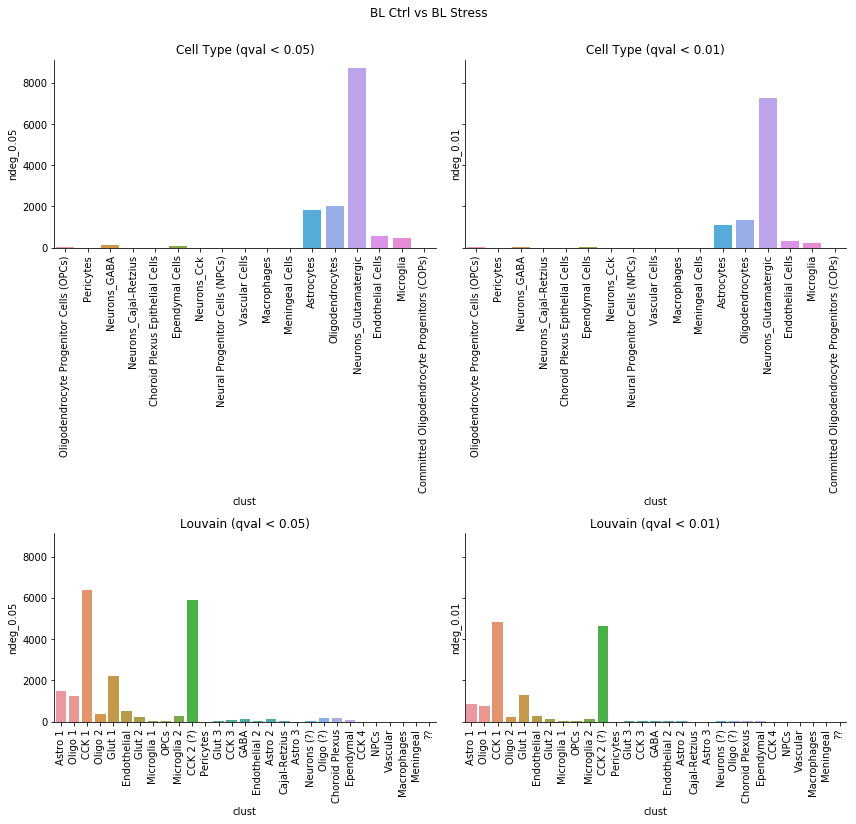

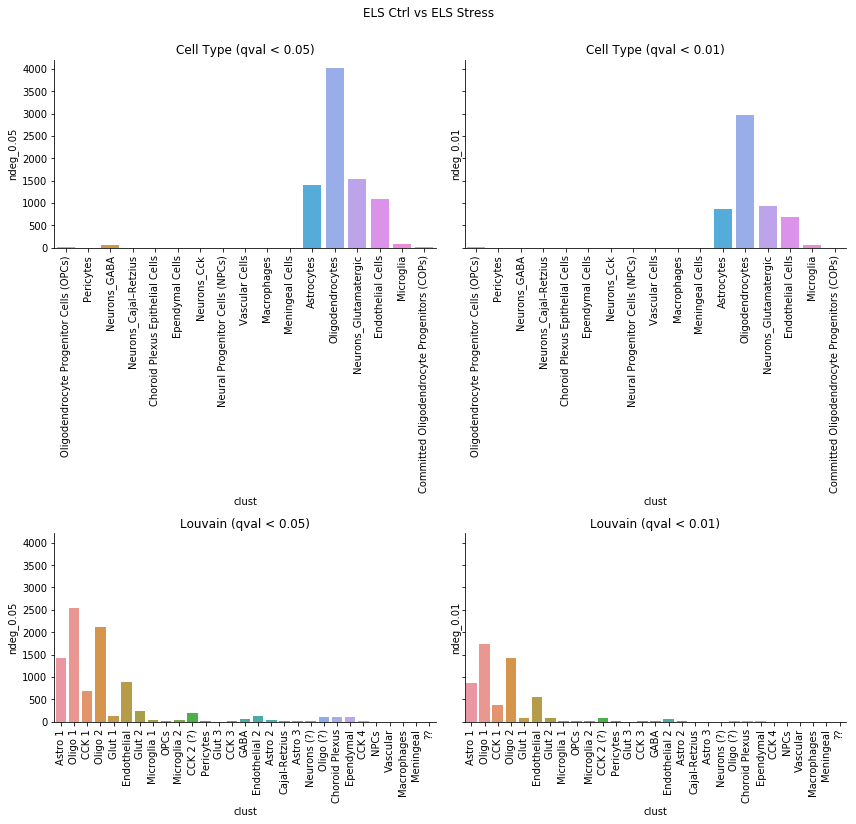

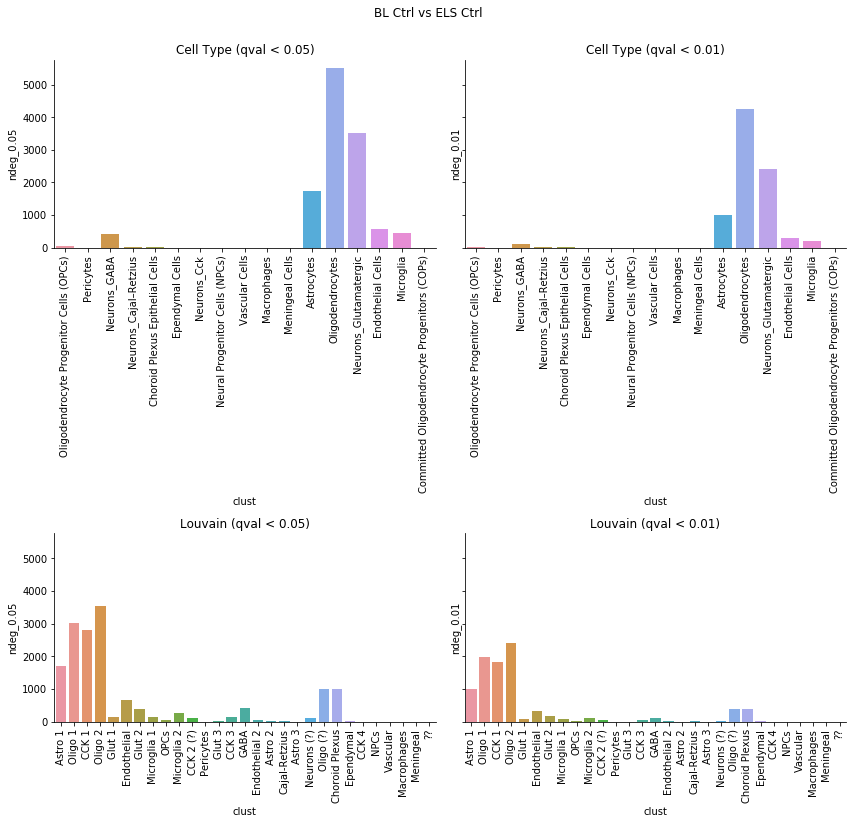

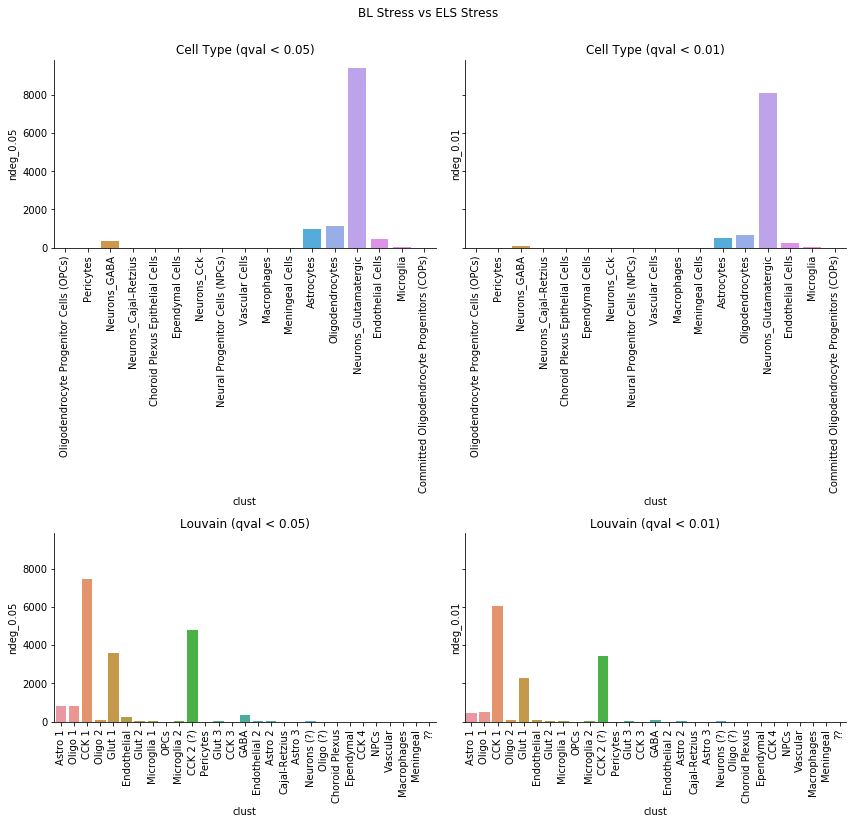

In [57]:
for pairtest in de_post_df['pairtest'].unique():
    print(pairtest)
    fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
    
    tmp_df = de_post_df[de_post_df['pairtest']== pairtest]
    
    tmp_df_celltype = tmp_df[tmp_df['clust_type']=='cell_type']
    sns.barplot(x='clust', y='ndeg_0.05', data=tmp_df_celltype, ax=ax[0, 0])
    ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)
    ax[0, 0].set_title('Cell Type (qval < 0.05)')

    sns.barplot(x='clust', y='ndeg_0.01', data=tmp_df_celltype, ax=ax[0, 1])
    ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=90)
    ax[0, 1].set_title('Cell Type (qval < 0.01)')

    tmp_df_louvain = tmp_df[tmp_df['clust_type']=='louvain']
    sns.barplot(x='clust', y='ndeg_0.05', data=tmp_df_louvain, ax=ax[1, 0])
    ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=90)
    ax[1, 0].set_title('Louvain (qval < 0.05)')

    sns.barplot(x='clust', y='ndeg_0.01', data=tmp_df_louvain, ax=ax[1, 1])
    ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)
    ax[1, 1].set_title('Louvain (qval < 0.01)')
    sns.despine()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(pairtest)
    fig.savefig('../figures/DE_' + pairtest.replace(' ', '_') + '.png', dpi=200)

Cluster Oligodendrocyte Progenitor Cells (OPCs):


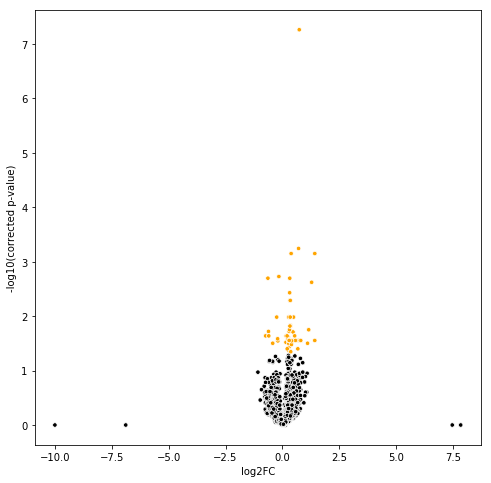

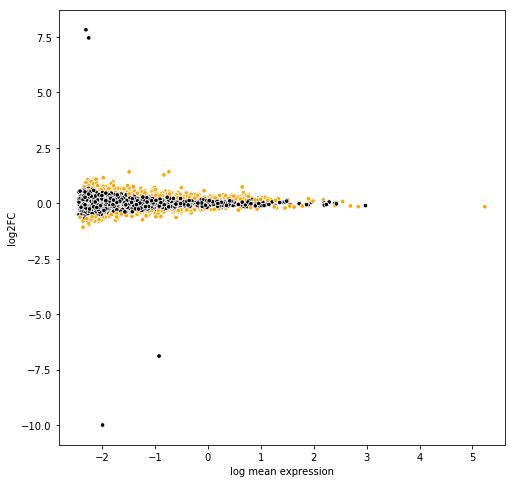

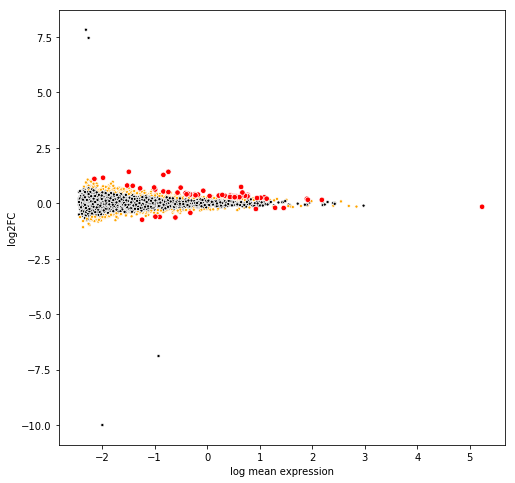

Cluster Pericytes:


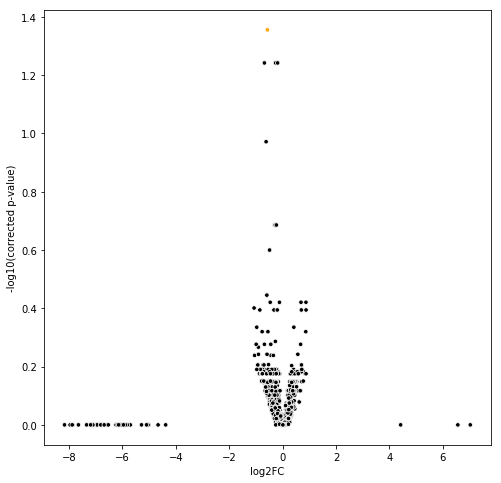

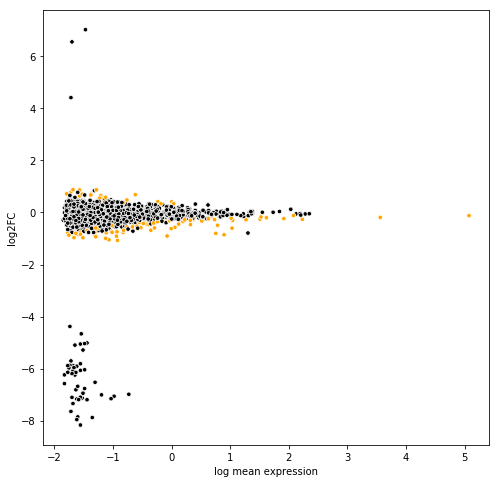

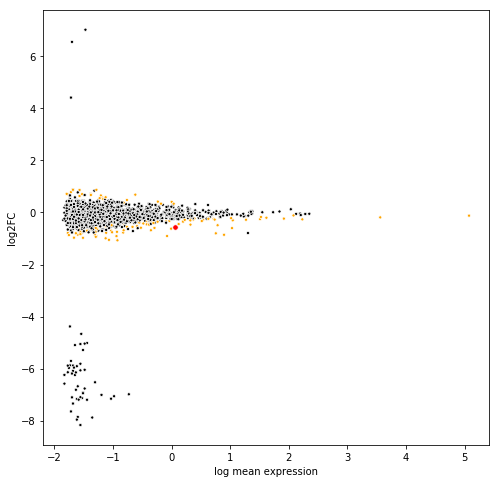

Cluster Neurons_GABA:


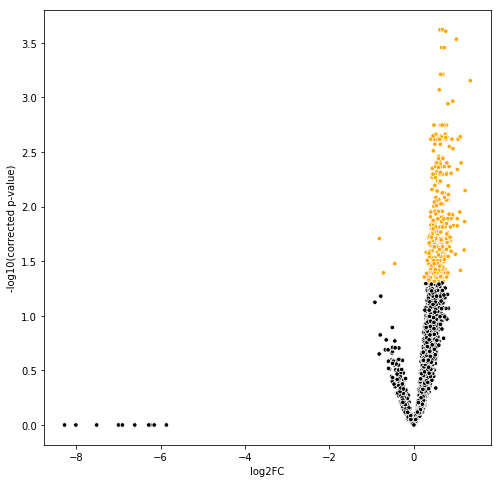

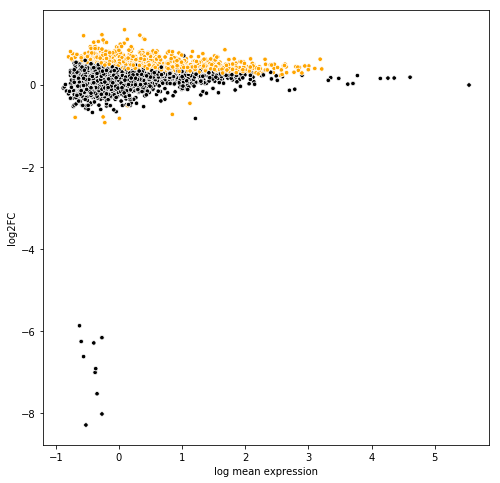

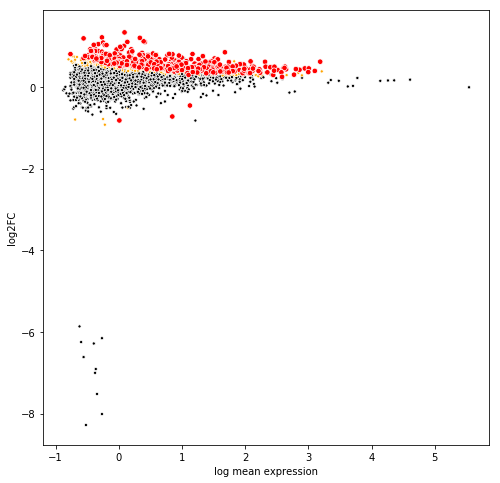

Cluster Neurons_Cajal–Retzius:


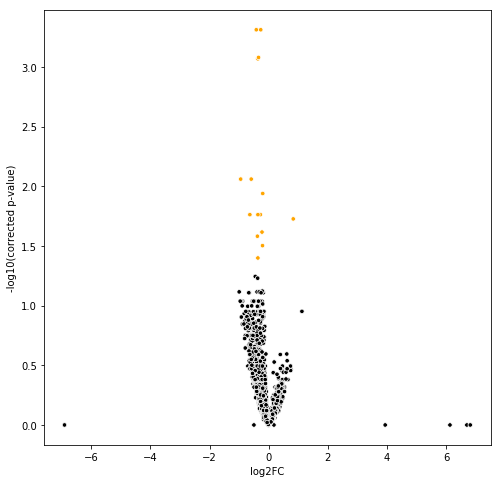

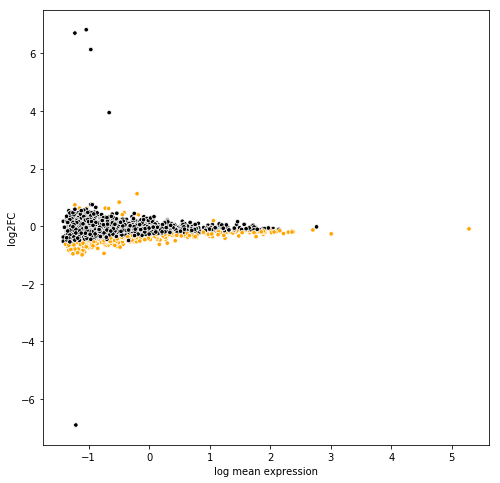

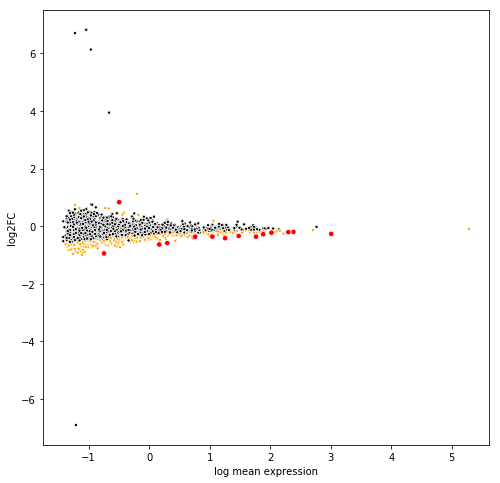

Cluster Choroid Plexus Epithelial Cells:


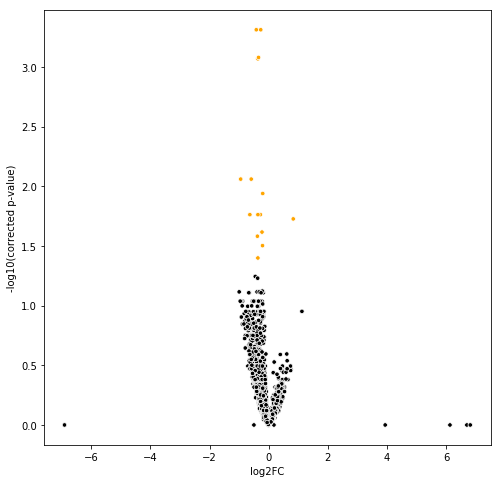

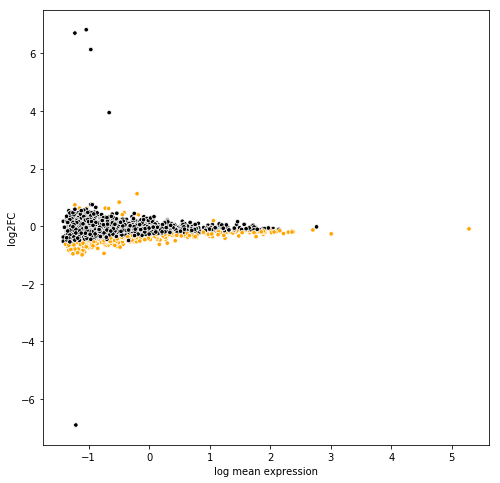

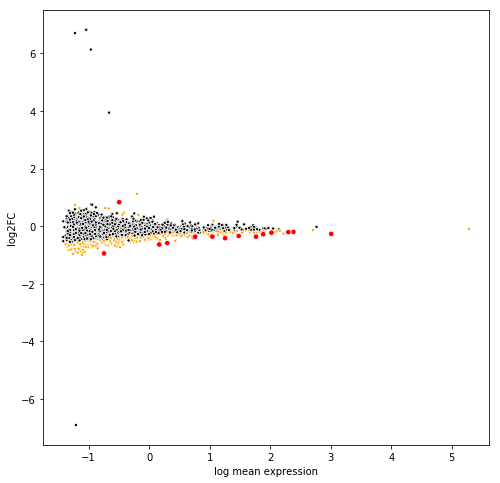

Cluster Ependymal Cells:


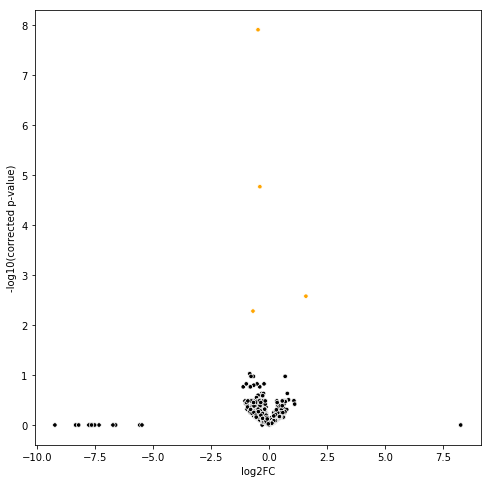

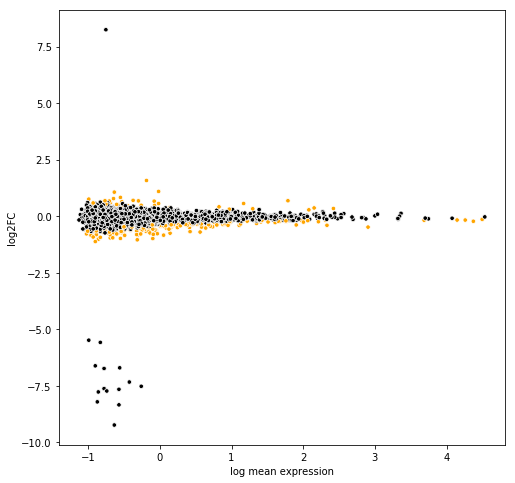

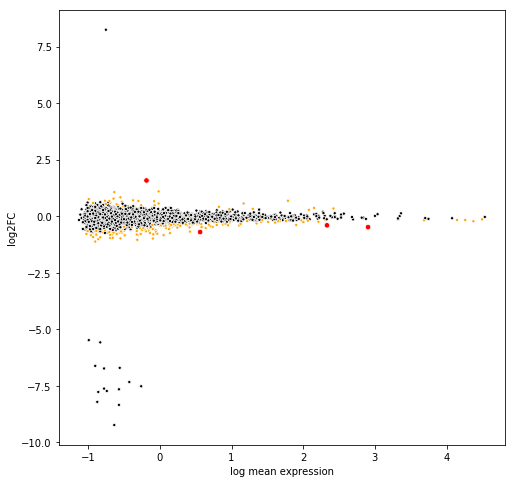

Cluster Neurons_Cck:


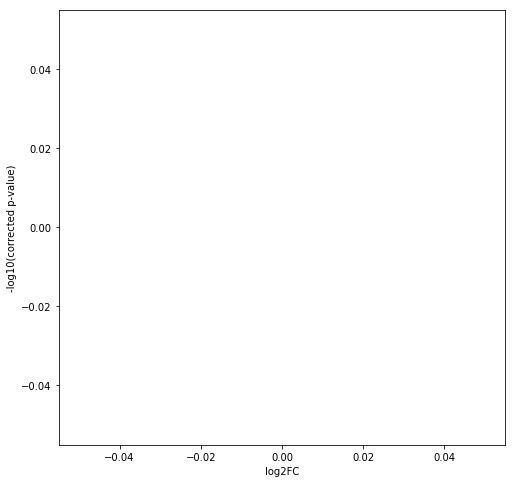

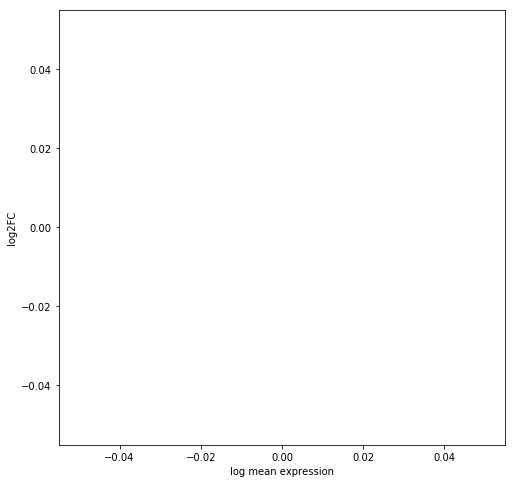

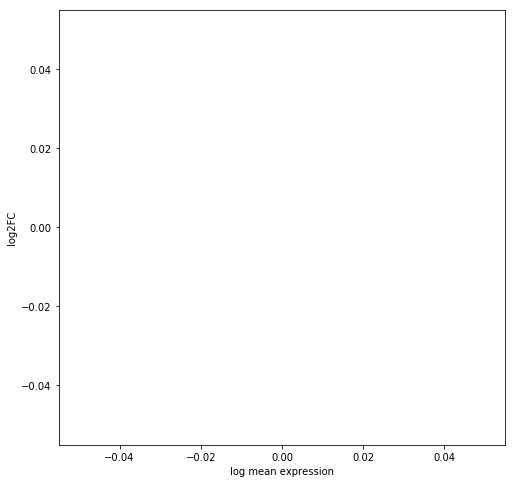

Cluster Neural Progenitor Cells (NPCs):


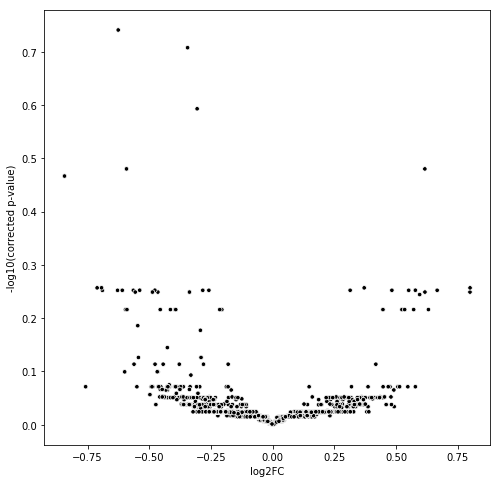

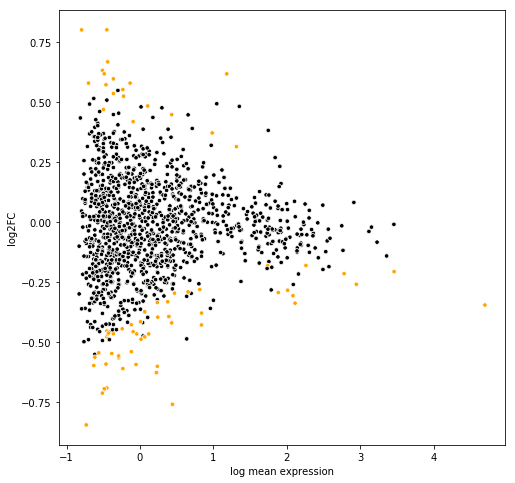

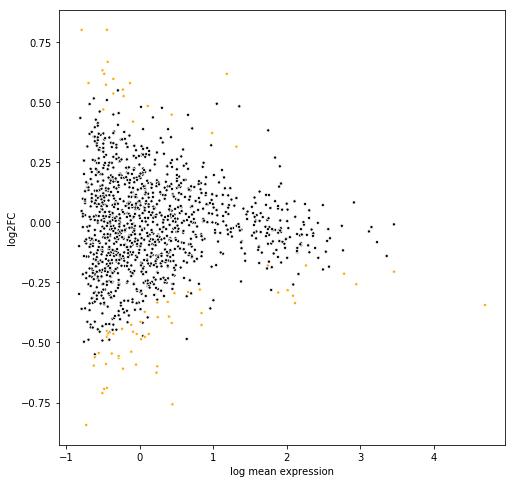

Cluster Vascular Cells:


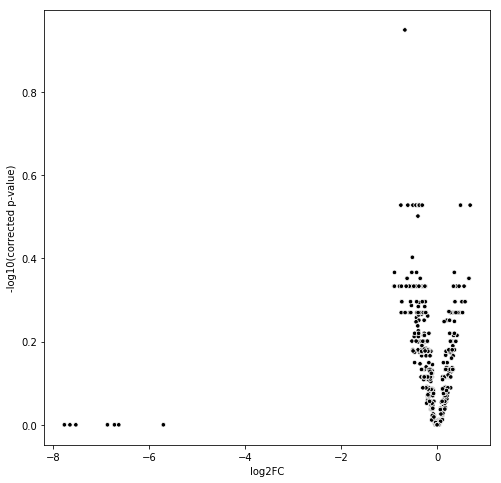

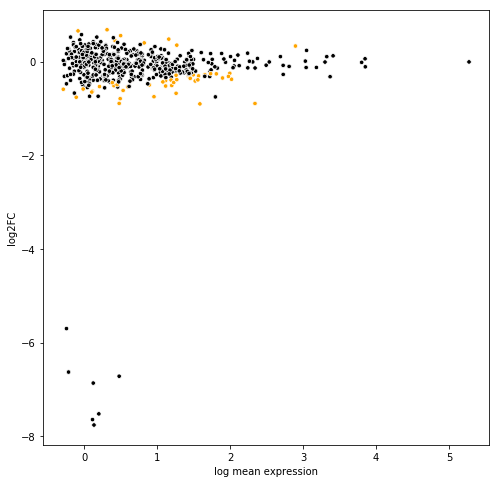

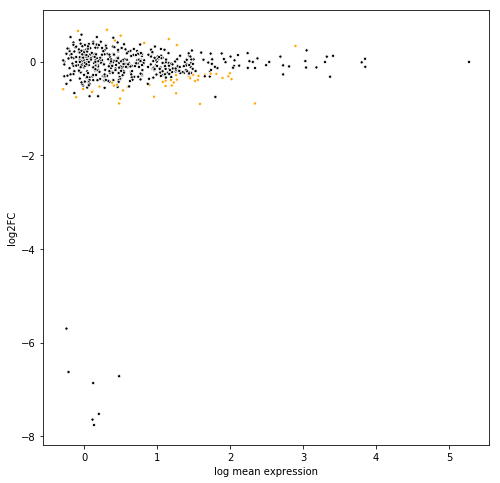

Cluster Macrophages:


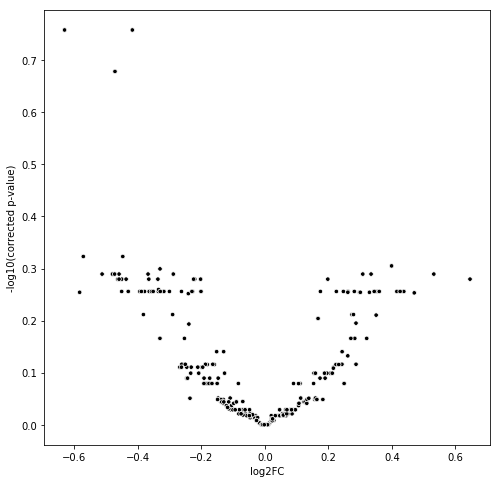

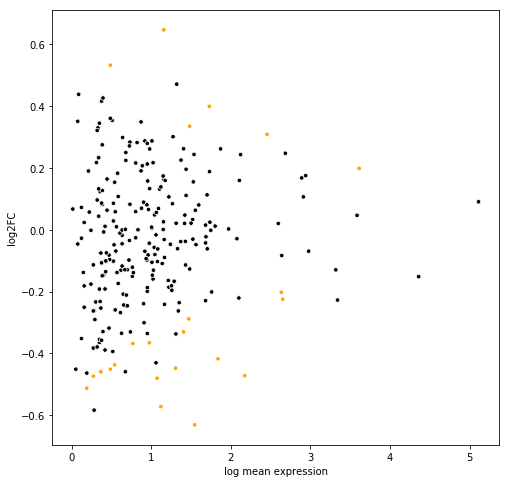

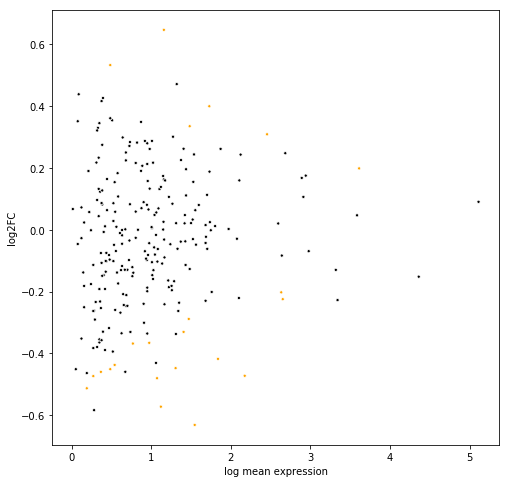

Cluster Meningeal Cells:


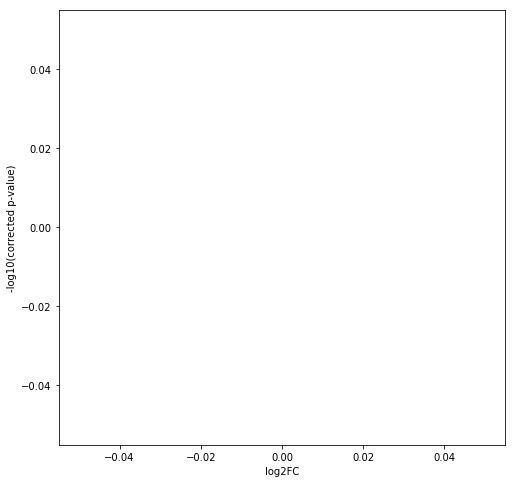

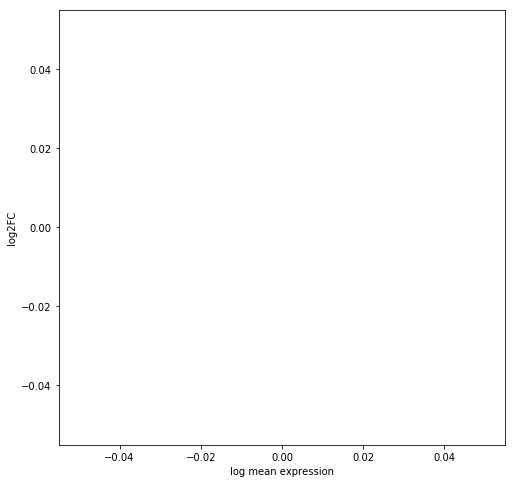

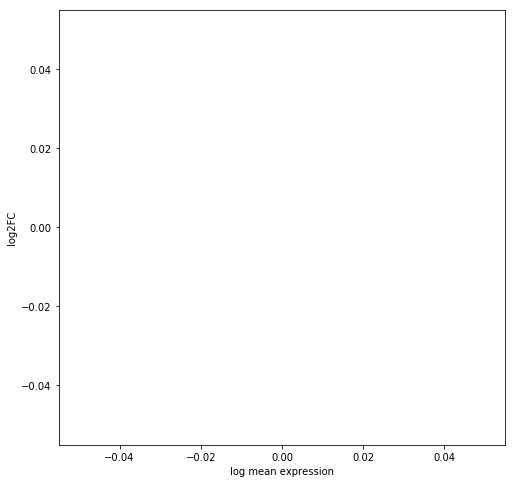

Cluster Astrocytes:


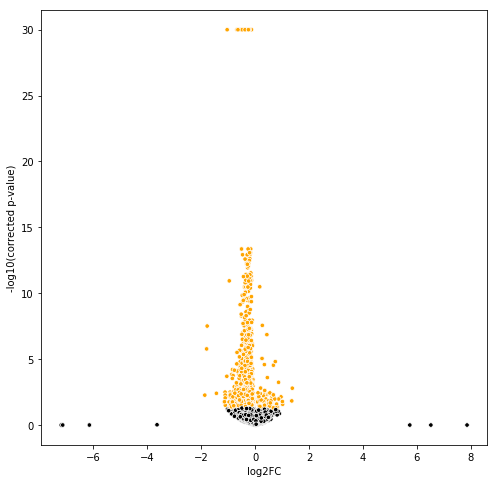

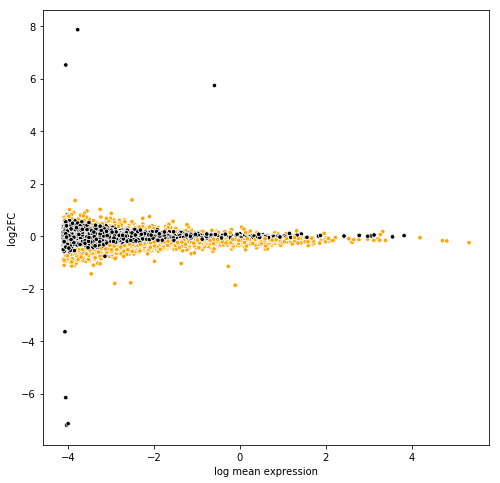

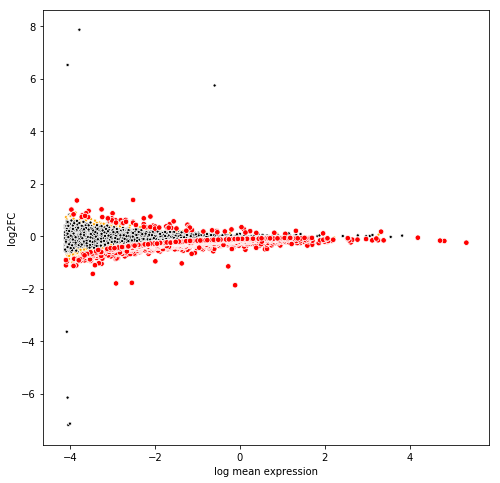

Cluster Oligodendrocytes:


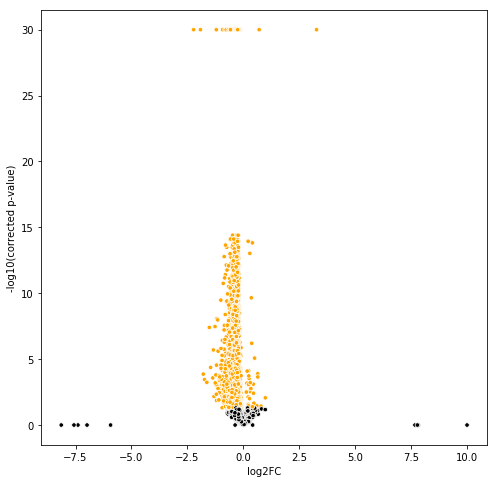

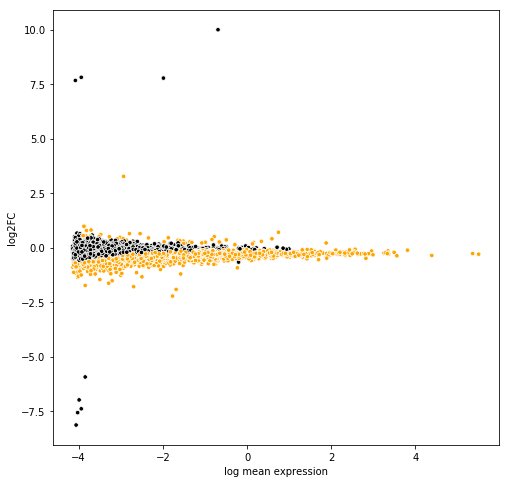

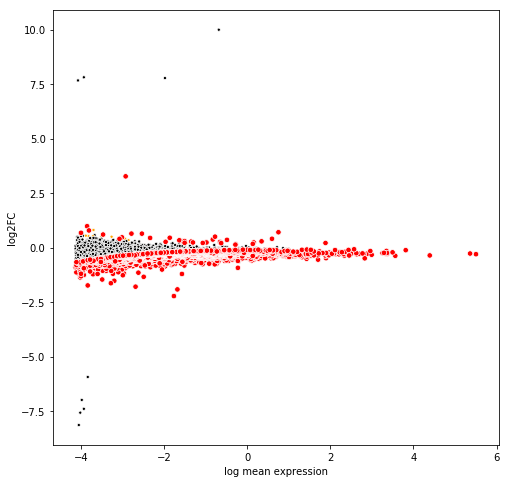

Cluster Neurons_Glutamatergic:


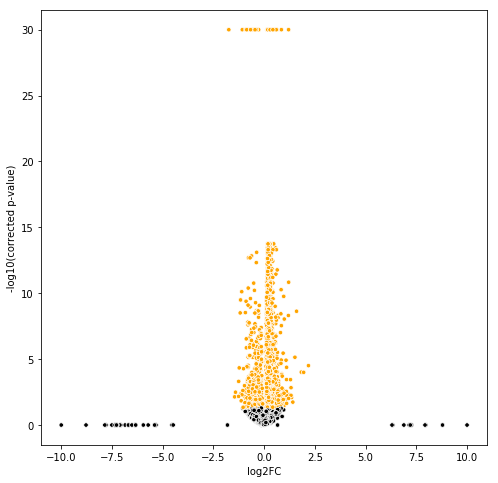

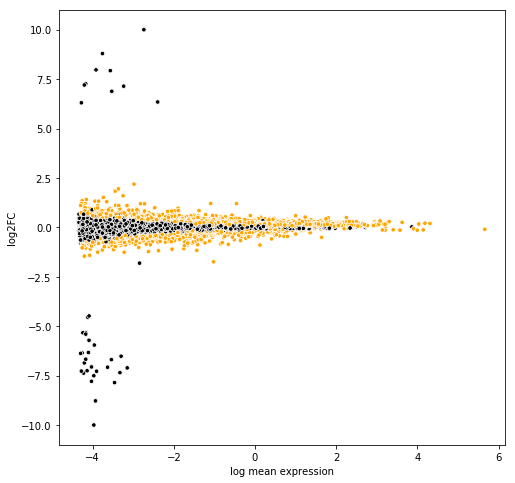

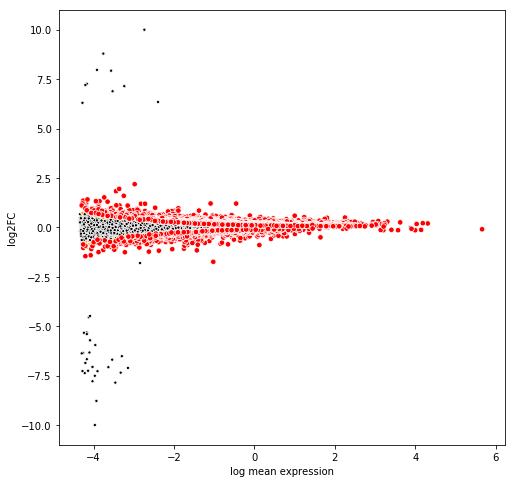

Cluster Endothelial Cells:


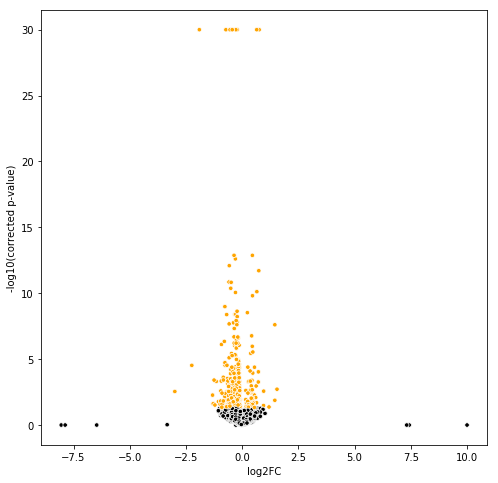

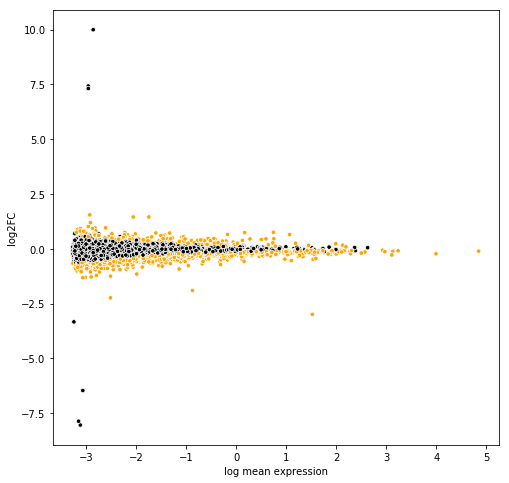

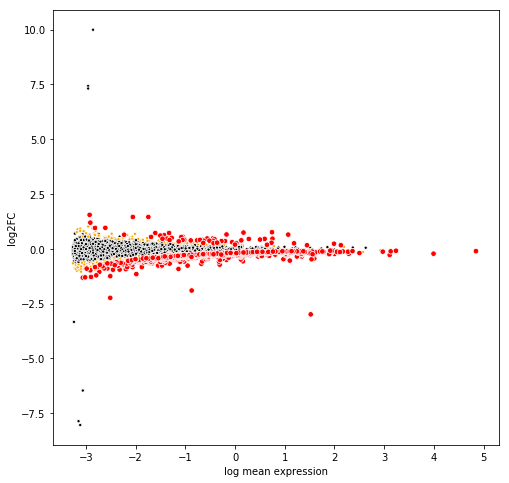

Cluster Microglia:


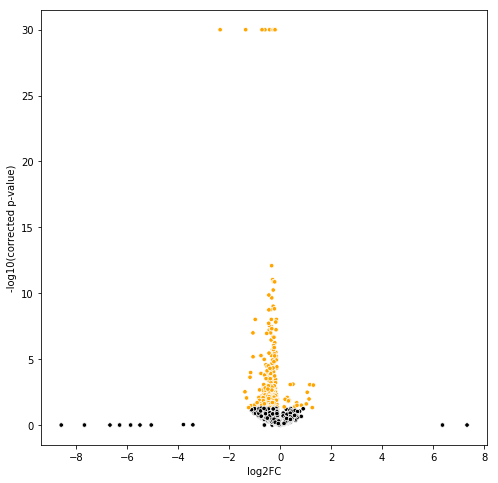

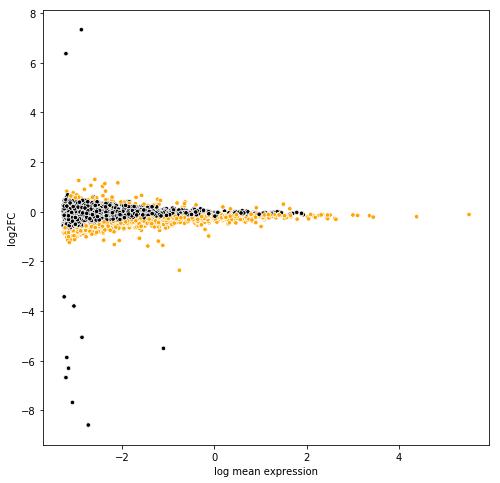

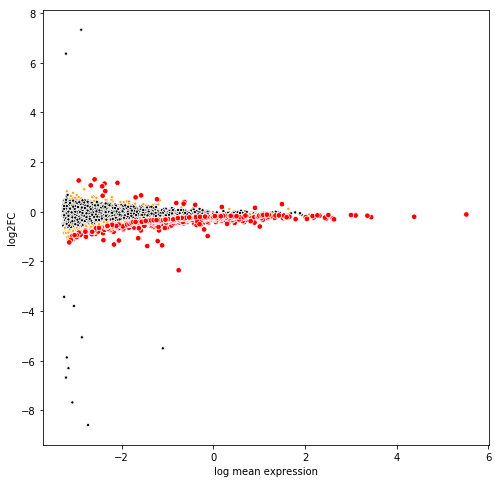

Cluster Committed Oligodendrocyte Progenitors (COPs):


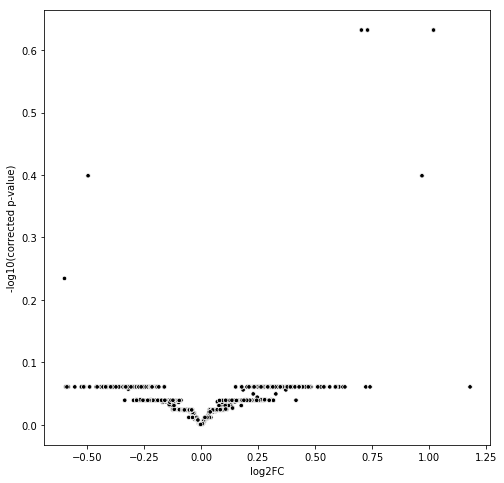

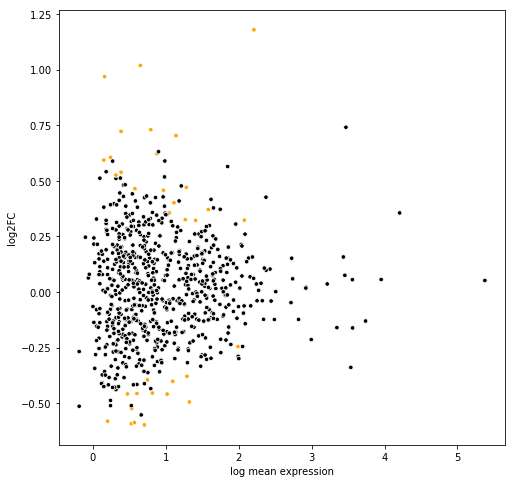

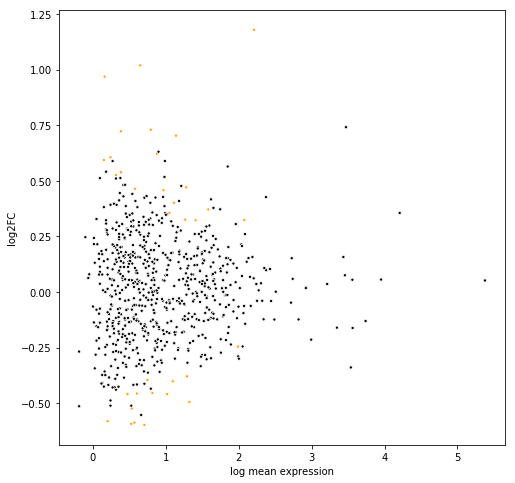

In [83]:
for clust in de_results_coarse:
    if clust in adata.obs['cell_type'].cat.categories:
        print(f'Cluster {clust}:')
        de_results_coarse[clust].plot_volcano(size=10, highlight_ids = np.asarray(de_full_res_coarse[clust]['gene'][de_full_res_coarse[clust]['qval'] < 0.05]))
        #de_results_coarse[clust].plot_ma()
        #de_results_coarse[clust].plot_ma(size=10, highlight_ids = np.asarray(de_full_res_coarse[clust]['gene'][de_full_res_coarse[clust]['qval'] < 0.05]))